In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from __future__ import absolute_import, division, print_function

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, Conv2D, Activation
from tensorflow.keras import Model


In [0]:
import os,sys,inspect
import os
import joblib
import tensorflow as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import scipy.io as sio
# import process_data

from google.colab import files

In [0]:
%load_ext autoreload
%autoreload 1
%aimport graph
%aimport coarsening
%aimport utils

In [0]:
# Graphs.
number_edges = 8
metric ='euclidean'
normalized_laplacian = True
coarsening_levels = 4
len_img = 28

In [0]:
# Load dataset from local

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
 

In [0]:
# Useful functions

def grid_graph(m):
    z = graph.grid(m)  # normalized nodes coordinates
    dist, idx = graph.distance_sklearn_metrics(z, k=number_edges, metric=metric) 
    #dist contains the distance of the 8 nearest neighbors for each node indicated in z sorted in ascending order
    #idx contains the indexes of the 8 nearest for each node sorted in ascending order by distance

    A = graph.adjacency(dist, idx)  # graph.adjacency() builds a sparse matrix out of the identified edges computing similarities as: A_{ij} = e^(-dist_{ij}^2/sigma^2)
    
    return A, z

  
def plot_matrix(m):
  plt.figure(figsize = (10, 10))
  plt.imshow(m.toarray())
  plt.show


def convert_coo_to_sparse_tensor(L):
        indices = np.column_stack((L.row, L.col))
        L = tf.SparseTensor(indices, L.data.astype('float32'), L.shape)
        L = tf.sparse.reorder(L)
        return L

      
def get_neighbour_indices(A, node_index):
    indices = A.indices[tf.equal(A.indices[:,0], node_index)][:,1]
    return indices

  
def get_neighbour_features(X, neighbour_indices):
    X = tf.constant(X)
    features = tf.gather(X, neighbour_indices)
    return features
  

def mask():
  space = np.arange(-1, 2)
  X, Y  = np.meshgrid(space,space)
  mask = np.array((X.ravel(), Y.ravel())).T
  mask = np.array([mask[:mask.shape[0]//2], mask[mask.shape[0]//2 + 1 :]])
  mask = mask.reshape((-1, 2))
  return tf.constant(mask.astype(np.float32))


In [135]:
# Load MNIST dataset

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
y_train = y_train.astype(np.float32) 
y_test = y_test.astype(np.float32)

val_n = len(x_train)//100 * 15
(x_val, y_val) = x_train[0:val_n], y_train[0:val_n]
(x_train, y_train) = x_train[val_n:], y_train[val_n:]

x_train = x_train.reshape(-1, len_img*len_img)
x_val = x_val.reshape(-1, len_img*len_img)
x_test = x_test.reshape(-1, len_img*len_img)

x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.float32)

print(x_train.shape)

(51000, 784)


In [0]:
# Load adjacency matrix

A, nodes_coordinates = grid_graph(len_img)
A = convert_coo_to_sparse_tensor(A.tocoo())

print(A.indices)
A.indices.shape

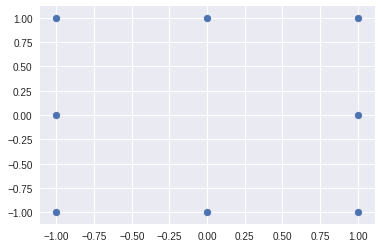

(8, 2, 1)


In [136]:
# Compute MNIST mask
u = mask()

plt.scatter(u[:,0], u[:,1])
plt.show()

u = np.reshape(u, (8,2,1))
print(u.shape)

In [0]:
# Create Gaussian weightning 

class Weighting(Layer):

  def __init__(self, d, **kwargs):
    self.d = d
    super(Weighting, self).__init__(**kwargs)

  def build(self, input_shape):
    self.mu = self.add_weight(name='mu', 
                              shape=(input_shape[-1], self.d),
                              initializer='uniform',
                              trainable=True)
    self.sigma = self.add_weight(name='sigma', 
                                 shape=(input_shape[-1], self.d),
                                 initializer='uniform',
                                 trainable=True)
    super(Weighting, self).build(input_shape)  

  def call(self, u):
    features = tf.shape(u)[-1]
    neighbours = tf.shape(u)[0]

    u = tf.reshape(u, (neighbours, 1, self.d)) 
    mu = tf.reshape(self.mu, (1, features, self.d))
    sigma = tf.reshape(self.sigma, (1, features, self.d))
#     u = (8,1,2)
#     mu = (1,1,2)
#     sigma = (1,1,2)
    
    diff =  (u - mu)**2
    factor = 1e-14 + sigma**2
    weights = -0.5 * (diff / factor)
#     weights = (8,1,2)
    weights = tf.math.reduce_sum(weights, axis=-1)
#     weights = (8,1)
    weights = tf.math.softmax(weights, axis=0)

    return weights 
    
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

  

# Create Gaussian (kernel) layer

class MoNet(Layer):

  def __init__(self, d, u, n, n_classes, **kwargs):
    self.d = d
    self.u = u
    self.n = n
    self.n_classes = n_classes
    self.w = Weighting(d=self.d, input_shape=(self.n,))(self.u)
    super(MoNet, self).__init__(**kwargs)

  def build(self, input_shape):
    self.W = self.add_weight(name='W', 
                             shape=(input_shape[-1], self.n_classes),
                             initializer='uniform',
                             trainable=True)
    super(MoNet, self).build(input_shape)  # Be sure to call this at the end

  def call(self, x):

    print(x.shape)
    D = self.w
        
    return D

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

In [0]:
# Hyperparameters

epochs=30
batch_size = 64
d = 2
n = 8
n_classes=10

In [0]:
# Build the model

model = Sequential()
model.add(MoNet(d, u, n, n_classes=n_classes, input_shape=(784,)))
# model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
# Train the model

model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=epochs, batch_size=batch_size)

In [0]:
# x = np.random.rand(8,1)
# y = np.random.rand(8,1,2)

# # x = np.reshape(x, (1, 1, 2))
# # y = np.reshape(y, (1, 1, 2))

# # x = np.transpose(x)
# # y = np.transpose(y)

x = np.array([[5.8979456e+21],
              [1.4278737e+16],
              [2.9690818e+22],
              [4.4364922e+05],
              [2.2333682e+06],
              [2.8810419e+24],
              [6.9749103e+18],
              [1.4503384e+25]])
print(x)
# print(y)

# z = x * y
# z

In [0]:
x = tf.math.softmax(x, axis=0)
print(x)
print(np.sum(x))

In [155]:
k = Weighting(d=d, input_shape=(n,))
k(u)

# k = Gaussian(d, u, n, n_classes=n_classes, input_shape=(784,))
# k(x_train[0,:])


<tf.Tensor: id=5996, shape=(8, 1), dtype=float32, numpy=
array([[0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [1.000000e+00],
       [3.536261e-21],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00]], dtype=float32)>